# Ejemplo 4: CONSTR test problem

$$ min \hspace{0.25cm} F(x) = (f_1(x_1,x_2), f_2(x_1,x_2)) $$

Donde:

$$ f_1(x_1,x_2) = x_1 $$
$$ f_2(x_1,x_2) = \frac{(1+x_2)}{x_1}$$

Sujeto a:

$$ g_1(x_1,x_2) = x_2 + 9x_1 \geq 6 $$
$$ g_2(x_1,x_2) = -x_2 + 9x_1 \geq 1 $$
$$ 0.1 \leq x_1 \leq 1.0 $$
$$ 0 \leq x_2 \leq 5.0 $$

In [1]:
# importar librerias
import numpy as np
from scipy.optimize import minimize, Bounds # se utilizará scipy para resolver el problema de optimización
import matplotlib.pyplot as plt
%matplotlib widget

## Weighting method

Para implementar el método de los pesos de debe implementar la siguente función:

$$ min \hspace{0.25cm} F(x_1,x_2) = w\cdot f_1(x_1,x_2) + (1-w)\cdot f_2(x_1,x_2) \tag{1}$$

Donde $w$ es el peso que indica la prioridad del objetivo:

- Si $w=1$ se transforma en un problema de solo un objetivo priorizando $f_1(x_1,x_2)$
- Si $w=0$ se transforma en un problema de solo un objetivo priorizando $f_2(x_1,x_2)$
- Si $0\lt w \lt 1$; valores más cercanos a $1$ priorizan $f_1(x_1,x_2)$, mientras que valores más cercanos a $0$ priorizan $f_2(x_1,x_2)$

Se implementa (1) en la función `constr_fun_w`

In [2]:
def constr_fun_w(x, w):
    
    f1 = x[0]
    f2 = (1+x[1])/x[0]  
    
    f = w*f1+(1-w)*f2
    
    return f

Se crea función `constraint` la cual contiene las inecuaciones de desigualdad $g_1(x_1,x_2)$ y $g_2(x_1,x_2)$

In [3]:
def constraint(x):
    
    g = np.zeros(2)
    
    g[0] = x[1]+9*x[0]-6
    g[1] = -x[1]+9*x[0]-1
    
    return g    

In [4]:
# se debe definir este dicccionario para ingresar la restricicón en la función minimize
constraint = {'type': 'ineq', 'fun': constraint} 
# valores iniciales de la optimización (initial guess)
x0 = np.array([0.5, 2.5])
# lower bound
xL = np.array([0.1, 0])
# upper bound
xU = np.array([1.0, 5.0])
bounds = Bounds(xL, xU)
# creamos un vector con diferentes valores de w entre 0 y 1
n_run = 100
w = np.linspace(0,1,n_run)
# creamos un vector para almacenar los diferentes resultados para cada optimización
x_pareto = np.zeros([100,2])

In [5]:
# hacemos un bucle para recorrer todos los valores de w
for i in range(len(w)):
    # dentro del blucle llamamos a la función minimize que realiza la optimización
    sol = minimize(constr_fun_w,x0, method='SLSQP',\
                    bounds=bounds, args = (w[i],), constraints=constraint, options = {'disp':False})
    # almacenamos para cada w la solución x*
    x_pareto[i,:] = sol.x 

In [6]:
# calculamos el valor de f2
# f1 es igual a x1
f2 = (1+x_pareto[:,1])/x_pareto[:,0]

Text(0, 0.5, '$f_2(x)$')

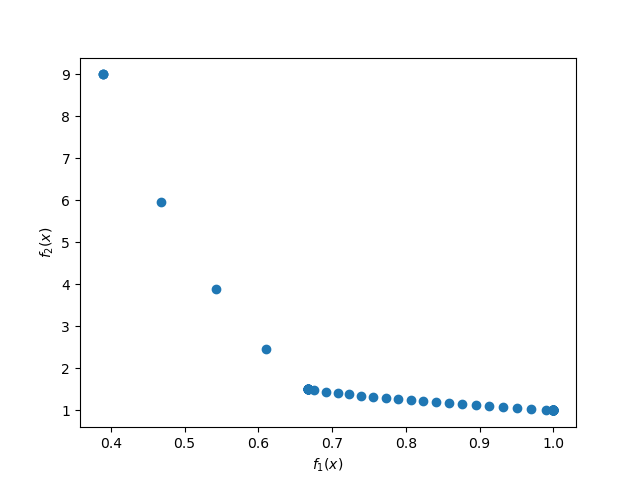

In [8]:
# graficamos el resultado de f1 vs f2
plt.figure()
plt.scatter(x_pareto[:,0], f2)
plt.xlabel('$f_1(x)$')
plt.ylabel('$f_2(x)$')

## $\varepsilon$-Constraint method

Para implementar el método $\varepsilon$-constraint se debe escoger solo una función objetivo y la otra debe pasar a ser una restricción.

En este caso se escogerá $f_2(x_1,x_2)$ como función objetivo y $f_1(x_1,x_2)$. Por lo tanto, el problema de optimización queda de la siguente forma:

$$ min \hspace{0.25cm} f_2(x_1,x_2) \tag{2}$$

sujeto a:
$$ f_1(x_1,x_2) =x_1 \leq \varepsilon $$
$$ g_1(x_1,x_2) = x_2 + 9x_1 \geq 6 $$
$$ g_2(x_1,x_2) = -x_2 + 9x_1 \geq 1 $$
$$ 0.1 \leq x_1 \leq 1.0 $$
$$ 0 \leq x_2 \leq 5.0 $$

Se implementa (2) en la función `constr_fun_e`

In [9]:
def constr_fun_e(x):
    
    f2 = (1+x[1])/x[0]
    return f2

Se debe crear una función adicional para la $\varepsilon$-constraint. En este caso la función se implementa de la siguente forma:

$$ x_1 \leq \varepsilon \tag{3}$$

Las restricciones en la función `minimize` se deben implementar de la siguente forma:

$$ g(x) \geq 0 $$

Por lo tanto (3) se debe escribir de la forma:

$$ \varepsilon - x_1 \geq 0 \tag{4}$$

La expresión (4) se implementa en la función `constraint_obj1`

In [10]:
def constraint_obj1(x, e_constraint):
    
    g = e_constraint-x[0]
    return g

In [11]:
# creamos un vector con diferentes valores de epsilon entre 0.1 y 1.0 que corresponden a sus lower y upper bounds
e_cons = np.linspace(0.1,1.0,100)
# creamos un vector para almacenar los diferentes resultados para cada optimización
x_pareto_e = np.zeros([100,2])
# hacemos un bucle para recorrer todos los valores de epsilon
for i in range(len(e_cons)):
    cons_obj1 ={'type': 'ineq', 'fun': constraint_obj1, 'args': (e_cons[i],)} # creamos la epsilon contraint para cada valor del vector
    cons = ([constraint, cons_obj1]) # unimos la epsilon constraint con las restricciones g1 y g2
    # dentro del blucle llamamos a la función minimize que realiza la optimización
    sol_e = minimize(constr_fun_e, x0, method='SLSQP', bounds=bounds, constraints= cons, options = {'disp':False})
     # almacenamos para cada w la solución x*
    x_pareto_e[i,:] = sol_e.x

In [12]:
# calculamos el valor de f2
f2_e = (1+x_pareto_e[:,1])/x_pareto_e[:,0]

In [13]:
# graficamos el resultado de f1 vs f2
plt.scatter(x_pareto_e[:,0], f2_e)
plt.xlabel('$f_1(x)$')
plt.ylabel('$f_2(x)$')

Text(83.83333333333334, 0.5, '$f_2(x)$')

## Comparación weighting method y $\varepsilon$-constraint

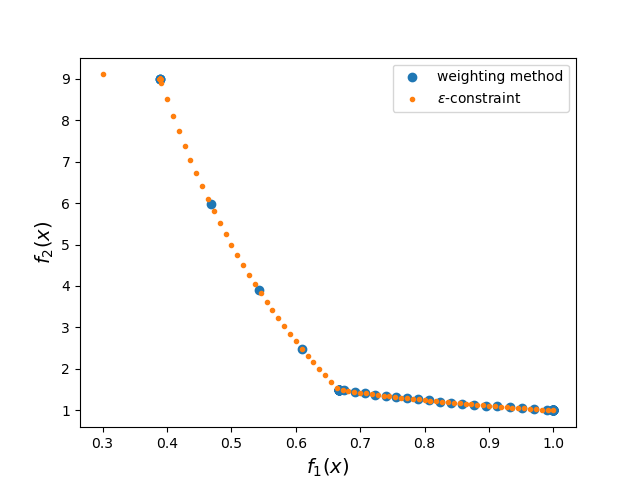

In [14]:
plt.figure()
plt.scatter(x_pareto[:,0], f2, marker = 'o')
plt.scatter(x_pareto_e[:,0], f2_e, marker = '.')
plt.xlabel('$f_1(x)$', fontsize = 14)
plt.ylabel('$f_2(x)$', fontsize = 14)
plt.legend(['weighting method', '$\epsilon$-constraint'])

## NSGA-II con pymoo

In [15]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

In [16]:
class CONSTR_problem(ElementwiseProblem):
    
    def __init__(self):    
        # limites inferiores
        xL = np.array([0.1, 0.0])
        # limites superiores
        xU = np.array([1.0, 5.0])        
        super().__init__(n_var = 2, n_obj = 2, n_constr=2, xl = xL, xu = xU)
        
    def _evaluate(self, x, out, *args, **kwargs):       
        # funciones objetivos
        f1 = x[0]
        f2 = (1+x[1])/x[0]
        # restriciones de desigualdad
        # se escriben de la forma g(x) <= 0
        g1 = -x[1]-9*x[0]+6 # las ine
        g2 = x[1]-9*x[0]+1       
            
        out["F"] = [f1, f2]
        out["G"] = [g1, g2]

In [17]:
# %% inicializar el algoritmo
problem = CONSTR_problem()
algorithm = NSGA2(pop_size=100, n_offsprings=20, eliminate_duplicates=True)
# ejecutar problema de optimización
res = minimize(problem, algorithm, ("n_gen", 200), verbose=True, seed = 42)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      6 |  0.000000E+00 |  1.2483050410 |             - |             -
     2 |      120 |      6 |  0.000000E+00 |  0.4991191814 |  0.4313536443 |         ideal
     3 |      140 |      7 |  0.000000E+00 |  0.1017867026 |  0.0497185093 |         ideal
     4 |      160 |      9 |  0.000000E+00 |  0.0003083591 |  0.0273858982 |             f
     5 |      180 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0110549195 |             f
     6 |      200 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0136947427 |             f
     7 |      220 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0053699085 |             f
     8 |      240 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0043162381 |             f
     9 |      260 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0381732916 |         ideal
    10 |      280 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0028742406 |             f

Text(0, 0.5, '$f_{2}(x)$')

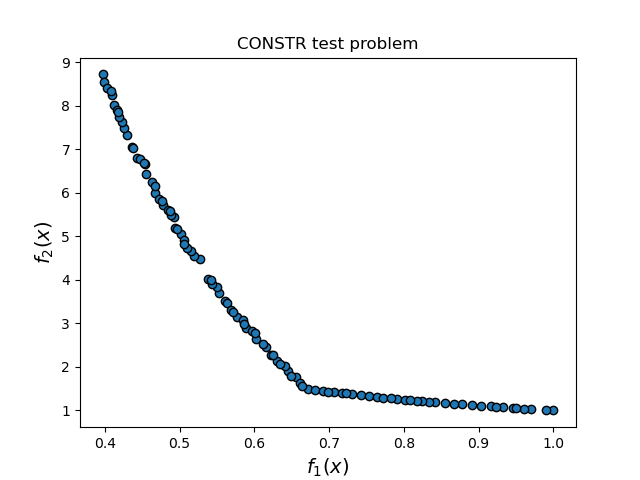

In [18]:
plt.figure()
plt.plot(res.F[:,0], res.F[:,1], 'o', markeredgecolor = 'black')
plt.title('CONSTR test problem')
plt.xlabel(r'$f_{1}(x)$', fontsize = 14)
plt.ylabel(r'$f_{2}(x)$', fontsize = 14)